In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2021-12-04 11:42:06.646158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-12-04 11:42:06.646189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570271209822294016,neutral,1.0,NaN,NaN,US Airways,NaN,JenRomanoff,NaN,0,@USAirways so I can make a reservation,NaN,2015-02-24 09:17:06 -0800,NaN,Eastern Time (US & Canada)
1,570015373447159808,negative,1.0,Customer Service Issue,1.0000,US Airways,NaN,bbuck22,NaN,0,@USAirways 1500 characters are not enough to c...,NaN,2015-02-23 16:20:30 -0800,"Las Vegas, NV",Pacific Time (US & Canada)
2,568810700828741633,negative,1.0,Lost Luggage,1.0000,United,NaN,TaylorWoot,NaN,0,"@United wind chill in Ithica -17 degrees, and ...",NaN,2015-02-20 08:33:33 -0800,Easley SC,Eastern Time (US & Canada)
3,568308793005617152,negative,1.0,Bad Flight,0.6813,United,NaN,themkhiggy,NaN,0,@united ^GJ flight 1101 didn't have wifi even ...,NaN,2015-02-18 23:19:09 -0800,"Houston, TX",Central Time (US & Canada)
4,569900705852608513,negative,1.0,Customer Service Issue,1.0000,American,NaN,tranpham18,NaN,0,@AmericanAir still no response from AA. great ...,NaN,2015-02-23 08:44:51 -0800,New York City,Eastern Time (US & Canada)


In [3]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,neutral,@USAirways so I can make a reservation
1,negative,@USAirways 1500 characters are not enough to c...
2,negative,"@United wind chill in Ithica -17 degrees, and ..."
3,negative,@united ^GJ flight 1101 didn't have wifi even ...
4,negative,@AmericanAir still no response from AA. great ...


<AxesSubplot:>

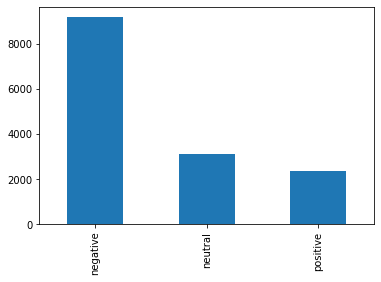

In [4]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

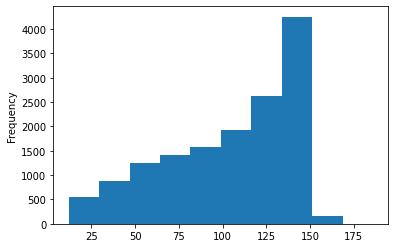

In [5]:
data['text'].str.len().plot.hist()

In [6]:
data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,neutral,@USAirways so I can make a reservation
1,negative,@USAirways 1500 characters are not enough to c...
2,negative,"@United wind chill in Ithica -17 degrees, and ..."
3,negative,@united ^GJ flight 1101 didn't have wifi even ...
4,negative,@AmericanAir still no response from AA. great ...


In [7]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0                USAirways so I can make a reservation
1    USAirways 1500 characters are not enough to co...
2    United wind chill in Ithica 17 degrees and for...
3    united ^GJ flight 1101 didnt have wifi even th...
4    AmericanAir still no response from AA great jo...
Name: text, dtype: object

In [8]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   12,   44,    3,   34,  124,    4,  235],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   12, 3670, 1371,
          35,   24,  463,    1,    2,  249,   23, 2225,    1, 4604,  206],
       [   0,    0,    0,    0,    0,    0,    0,    0,    5, 2723, 3098,
          15, 1600, 1916,   10,    7,    2,  954,   18,  774,   11,  794,
          54,  232,   19,    4, 4605,  217, 4606,   20,    7, 3671,    5],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    5, 2724,    8,  184,   22,
         289,  135,  374,   20,   23, 1257,    1,  101,   21,  410,  175],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [9]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

2021-12-04 11:43:59.363872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-12-04 11:43:59.363921: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-04 11:43:59.363948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-Laptop-15-da0xxx-def03a20): /proc/driver/nvidia/version does not exist
2021-12-04 11:43:59.364444: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 33, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 33, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [10]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
366/366 - 133s - loss: 0.6397 - accuracy: 0.7365 - 133s/epoch - 362ms/step
Epoch 2/8
366/366 - 161s - loss: 0.4252 - accuracy: 0.8343 - 161s/epoch - 440ms/step
Epoch 3/8
366/366 - 144s - loss: 0.3403 - accuracy: 0.8740 - 144s/epoch - 394ms/step
Epoch 4/8
366/366 - 134s - loss: 0.2740 - accuracy: 0.8978 - 134s/epoch - 365ms/step
Epoch 5/8
366/366 - 138s - loss: 0.2293 - accuracy: 0.9153 - 138s/epoch - 376ms/step
Epoch 6/8
366/366 - 144s - loss: 0.1869 - accuracy: 0.9314 - 144s/epoch - 394ms/step
Epoch 7/8
366/366 - 130s - loss: 0.1608 - accuracy: 0.9440 - 130s/epoch - 354ms/step
Epoch 8/8
366/366 - 122s - loss: 0.1396 - accuracy: 0.9503 - 122s/epoch - 333ms/step


In [15]:
model.save('sentiment_analysis.h5')

In [16]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

USAirways so I can make a reservation [0.5825522  0.38729173 0.03015606] [1 0 0]
USAirways 1500 characters are not enough to convey the issue Was directed to emailmailtocustomerrelationsusairwayscom unmonitored BAD [9.9999547e-01 4.2884567e-06 2.7407501e-07] [1 0 0]
United wind chill in Ithica 17 degrees and for the trouble of losing my clothes they give me a tshirt Ill burn it for warmth united [9.9985576e-01 1.3171928e-04 1.2490147e-05] [1 0 0]
united ^GJ flight 1101 didnt have wifi even though it was promised to by your ground crew AnotherDisappointment [9.9024642e-01 9.5578264e-03 1.9573586e-04] [1 0 0]
AmericanAir still no response from AA great job guys [2.5318720e-04 9.9884975e-01 8.9712162e-04] [1 0 0]


[None, None, None, None, None]

In [17]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 358
Neutral predictions: 582
Negative predictions: 1988
Real positive: 494
Real neutral: 629
Real negative: 1805
